# Intrusion Detection Model
### Outline
0. Setup
1. Load Data & Explore Correlation
2. Data Preprocessing
3. Define Model and Training args
4. Training and Evaluation

### 💎 Dataset
- UNSW-NB15 is downloaded at: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15/data
<hr width=70% style="float: left">

In [1]:
# Model is trained with GPU provided by googlecolab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>0. Set Up</b></h4>

* Import Library
* Build path to save model
</div>

In [2]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

import os
import sys
sys.path.append('/content/drive/MyDrive/Detect')

In [2]:
# Make path to save model
out_path = '/content/drive/MyDrive/Detect/result/'
if not os.path.exists(out_path):
     os.makedirs(out_path)

<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>1. Load Cleaned Data and Explore Correlation</b></h4>

* `train_test_split` is leveraged to split data into training, validation and testing set
* Correlation between features is calculated via `correlation_matrix`
</div>

In [3]:
data_clean = pd.read_csv('/content/drive/MyDrive/Detect/Detect_Data/cleaned.csv')
train, test = train_test_split(data_clean,test_size=0.2,random_state=16)
train, val = train_test_split(train,test_size=0.2,random_state=16)
train.shape

(1625629, 44)

In [5]:
del data_clean

In [6]:
x_train, y_train = train.drop(columns=['attack_cat']), train[['attack_cat']]
x_test, y_test = test.drop(columns=['attack_cat']), test[['attack_cat']]
x_val, y_val = val.drop(columns=['attack_cat']), val[['attack_cat']]

In [7]:
del train
del val
del test

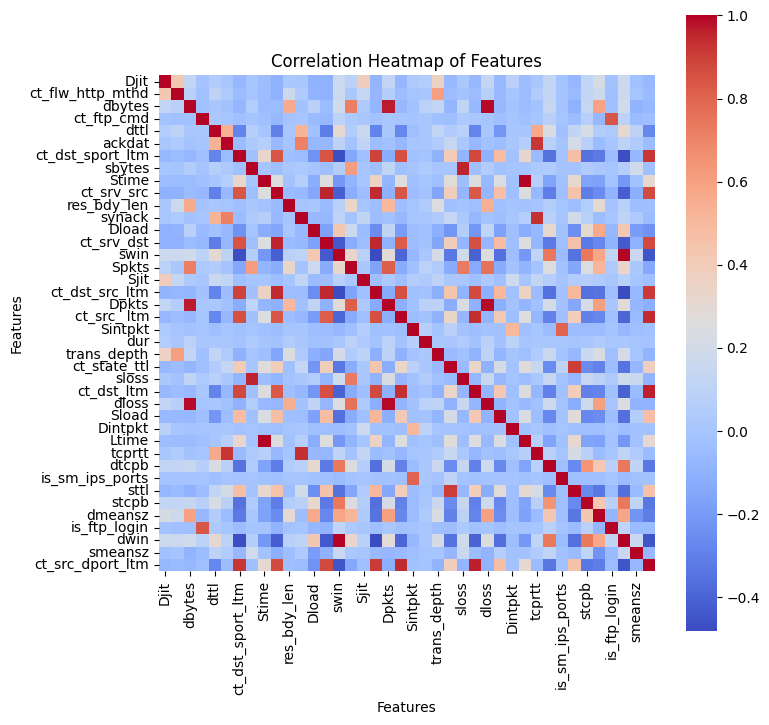

In [8]:
# Correlation
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

correlation_matrix = train[num_col].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', square=True)
# Add labels and title
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Heatmap of Features')

# Rotate x-axis labels for better readability with many features
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>2. Data Preprocessing</b></h4>

* `StandardScaler` is utilised for Numeric features.
* Categorical features are transformed via `OneHotEncoder`.
</div>

In [10]:
attacks = y_train['attack_cat'].unique()
attacks

array(['normal', 'generic', 'fuzzers', 'exploits', 'dos',
       'reconnaissance', 'backdoor', 'analysis', 'shellcode', 'worms'],
      dtype=object)

In [13]:
y_train['attack_cat'].value_counts()

attack_cat
normal            1420187
generic            137574
exploits            28640
fuzzers             15494
dos                 10454
reconnaissance       8985
analysis             1716
backdoor             1499
shellcode             979
worms                 101
Name: count, dtype: int64

In [14]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])
x_train[num_col] = scaler.transform(x_train[num_col])
x_test[num_col] = scaler.transform(x_test[num_col])
x_val[num_col] = scaler.transform(x_val[num_col])

In [15]:
x_train.head(3)

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
1070804,tcp,FIN,-0.015666,0.006680,-0.207565,-0.425819,-0.041571,0.078012,-0.165407,NaN,...,-0.197064,-0.132412,-0.111932,-0.295572,-0.552931,-0.298713,-0.231552,-0.429343,-0.4196,-0.341354
1054569,tcp,CON,-0.044727,-0.036739,-0.140409,-0.425819,-0.041571,0.078012,-0.112384,NaN,...,-0.197064,-0.132412,-0.111932,-0.664805,-0.183215,-0.543699,-0.718943,-0.429343,-0.4196,-0.519068
1548299,tcp,FIN,-0.045516,-0.026097,-0.061684,-0.425819,-0.041571,0.078012,-0.006337,NaN,...,-0.197064,-0.132412,-0.111932,-0.018647,-0.275644,-0.298713,0.133992,-0.429343,-0.4196,-0.519068


In [16]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), cat_col)], remainder='passthrough')
x_train = np.array(ct.fit_transform(x_train))
x_test = np.array(ct.transform(x_test))
x_val = np.array(ct.transform(x_val))

ct1 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(categories=[attacks],sparse=False), ['attack_cat'])], remainder='passthrough')
y_train = np.array(ct1.fit_transform(y_train))
y_test = np.array(ct1.transform(y_test))
y_val = np.array(ct1.transform(y_val))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>3. Define Model and Training args</b></h4>
</div>

In [12]:
'''
Another approach:
from Model import create_model

'''

def create_model():
    n_features = x_train.shape[1]  # Number of features from training data

    # Define the model
    model = Sequential()

    # First convolutional block
    model.add(Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(n_features,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # First LSTM block
    model.add(LSTM(units=16, return_sequences=True))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Second convolutional block
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Second LSTM block
    model.add(LSTM(units=32, return_sequences=True))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Third convolutional block
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # Third LSTM block
    model.add(LSTM(units=64))
    #model.add(Dropout(0.2))  # Added dropout after LSTM

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))  # Adjusted dropout rate for dense layer

    model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model


<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>4. Training and Evaluation</b></h4>

* The model is evaluated by standard criteria: Accuracy, Precision, Recall
</div>

In [13]:
model=create_model()
history = model.fit(x_train, y_train, epochs=5, batch_size=256,validation_data=(x_val,y_val))

 #Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Epoch 1/5
6351/6351 [==============================] - 132s 19ms/step - loss: 0.0737 - accuracy: 0.9724 - precision: 0.9894 - recall: 0.9602 - val_loss: 0.0638 - val_accuracy: 0.9743 - val_precision: 0.9887 - val_recall: 0.9640
Epoch 2/5
6351/6351 [==============================] - 116s 18ms/step - loss: 0.0606 - accuracy: 0.9764 - precision: 0.9898 - recall: 0.9667 - val_loss: 0.0575 - val_accuracy: 0.9769 - val_precision: 0.9903 - val_recall: 0.9679
Epoch 3/5
6351/6351 [==============================] - 115s 18ms/step - loss: 0.0576 - accuracy: 0.9773 - precision: 0.9902 - recall: 0.9681 - val_loss: 0.0545 - val_accuracy: 0.9782 - val_precision: 0.9904 - val_recall: 0.9694
Epoch 4/5
6351/6351 [==============================] - 115s 18ms/step - loss: 0.0555 - accuracy: 0.9778 - precision: 0.9903 - recall: 0.9689 - val_loss: 0.0542 - val_accuracy: 0.9780 - val_precision: 0.9905 - val_recall: 0.9692
Epoch 5/5
15876/15876 [==============================] - 112s 7ms/step - loss: 0.0533 - 

<div class="alert alert-block alert-warning">
<h4>👨🏽‍💻👩🏻‍💻 <b>5. Save the Model and Test on a single network packet</b></h4>

* Here, we randomly select a packet and the function `transform_packet` is applied to transform input form.Then, we use our trained model to make prediction by `identify_attack`.
</div>

In [14]:
# Save the Model
model.save(out_path+'detectThreat.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# Load our trained model
detect_model = tf.keras.models.load_model('/content/drive/MyDrive/Detect/result/detectThreat.h5')
idx_attack = {0:'Normal',1:'Generic',2:'Fuzzers',3:'Exploits',4:'DoS',5:'Reconnaissance',6:'Backdoor',7:'Analysis',8:'Shellcode',9:'Worms'}

# Define function to make prediction
def identify_attack(model,x,idx_attack):
    # Generate output
    pre = model.predict(x)

    # Selecting the classs as a prediction which has max probability
    y_pred = np.argmax(pre, axis=-1)
    idx = y_pred.item()
    attack = idx_attack[idx]
    return attack

In [ ]:
p=x_train.iloc[11:12]

# Map categorical features into numbers
proto_idx = {'tcp':0,'udp':1,'unas':2,'arp':3,'ospf':4}
service_idx = {'dns':0,'http':1,'ftp_data':2,'smtp':3,'ftp':4,'ssh':5,'pop3':6,'ssl':7,'dhcp':8,'snmp':9,'radius':10,'irc':11}
state_idx = {'FIN':0,'CON':1,'INT':2,'REQ':3,'RST':4,'ECO':5,'CLO':6,'URH':7,'ACC':8,'PAR':9,'MAS':10,'TST':11,'no':12,'URN':13,'ECR':14,'TXD':15}

# Modify captured packets before feeding into network
def transform_packet(p,proto_idx,service_idx,state_idx):
    #p['proto'],p['service'],p['state'] = proto_idx[p['proto']],service_idx[p['service']],state_idx[p['state']]
    #pro,ser,sta = p['proto'],p['service'],p['state']
    pro,ser,sta = p['proto'].item(),p['service'].item(),p['state'].item()
    p['proto'],p['service'],p['state'] = proto_idx[pro],service_idx[ser],state_idx[sta]
    num_col = ['Spkts','dbytes','res_bdy_len','Ltime','is_sm_ips_ports','trans_depth','ct_srv_dst','Stime','dwin','Sload',
     'Dintpkt','synack','dur','ct_dst_ltm','ct_ftp_cmd','ct_state_ttl','Sintpkt','stcpb','Dload','ct_srv_src',
     'dttl','Djit','Dpkts','sbytes','is_ftp_login','tcprtt','dmeansz','sttl','smeansz','ct_dst_src_ltm','dloss',
     'ct_src_dport_ltm','swin','sloss','ct_flw_http_mthd','ct_src_ ltm','ackdat','dtcpb','ct_dst_sport_ltm','Sjit']
    scaler = StandardScaler()
    scaler = scaler.fit(p[num_col])
    p[num_col] = scaler.transform(p[num_col])

    # Reshape into (1,num_features)
    p = np.array(p)
    #p = p[np.newaxis,:]

    return p

p = transform_packet(p,proto_idx,service_idx,state_idx)

In [115]:
# Predict Whether Attack Occurs
y2 = identify_attack(detect_model,p,idx_attack)
y2

1/1 [==============================] - 0s 86ms/step


'Normal'

In [112]:
# Check the ground truth
y_train.iloc[11:12]

,attack_cat
1888748,normal


#### Complete!